<a href="https://colab.research.google.com/github/pavankumarallu/Bolt-PRO/blob/main/BoltPro_Thermal_stability_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 95.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import re
from scipy.stats import randint
from scipy.stats import spearmanr
import plotly.express as px
from transformers import BertModel, BertTokenizer
import torch
import re
from tqdm import tqdm

In [4]:
def load_fixed_train_df(original_train_file_path="/content/drive/MyDrive/novozymes-enzyme-stability-prediction/train.csv",
                        update_file_path="/content/drive/MyDrive/novozymes-enzyme-stability-prediction/train_updates_20220929.csv",
                        was_fixed_col=False):
    def _fix_tm_ph(_row, update_map):
        update_vals = update_map.get(_row["seq_id"], None)
        if update_vals is not None:
            _row["tm"] = update_vals["tm"]
            _row["pH"] = update_vals["pH"]
        return _row

    # Load dataframes
    _df = pd.read_csv(original_train_file_path)
    _updates_df = pd.read_csv(update_file_path)

    # Identify which sequence ids need to have the tm and pH values changed and create a dictionary mapping 
    seqid_2_phtm_update_map = _updates_df[~pd.isna(_updates_df["pH"])].groupby("seq_id")[["pH", "tm"]].first().to_dict("index")

    # Identify the sequence ids that will be dropped due to data quality issues
    bad_seqids = _updates_df[pd.isna(_updates_df["pH"])]["seq_id"].to_list()

    # Fix bad sequence ids
    _df = _df[~_df["seq_id"].isin(bad_seqids)].reset_index(drop=True)

    # Fix pH and tm swaparoo
    _df = _df.apply(lambda x: _fix_tm_ph(x, seqid_2_phtm_update_map), axis=1)

    # Add in a bool to track if a row was fixed or not (tm/ph swap will look the same as bad data)
    if was_fixed_col: _df["was_fixed"] = _df["seq_id"].isin(bad_seqids+list(seqid_2_phtm_update_map.keys()))

    return _df

In [5]:
train_df = load_fixed_train_df()
test_df = pd.read_csv("/content/drive/MyDrive/novozymes-enzyme-stability-prediction/test.csv")
sub_df = pd.read_csv("/content/drive/MyDrive/novozymes-enzyme-stability-prediction/sample_submission.csv")

In [6]:
train_df.head()

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [7]:
train_df, val_df = train_test_split(train_df, test_size=0.20, random_state=42)

In [8]:
imputer = SimpleImputer(strategy="mean")
train_df["pH"] = imputer.fit_transform(train_df[["pH"]]).ravel()
val_df["pH"] = imputer.transform(val_df[["pH"]]).ravel()

In [9]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
model = BertModel.from_pretrained("Rostlab/prot_bert")
model.eval()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

Downloading:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/361 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda:0


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inplace=False

In [10]:
def extract_features(df):    
    embeddings_list = []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        sequence_Example = ' '.join(row["protein_sequence"])
        sequence_Example = re.sub(r"[UZOB]", "X", sequence_Example)
        encoded_input = tokenizer(sequence_Example, add_special_tokens=True, padding=True, is_split_into_words=True, return_tensors="pt").to(device)
        with torch.no_grad():
            output = model(**encoded_input)
            output = output[1].detach().cpu().numpy()[0]
            embeddings_list.append(output)
            torch.cuda.empty_cache()

    return embeddings_list

In [11]:
train_features = extract_features(train_df)
valid_features = extract_features(val_df)
test_features = extract_features(test_df)

  8%|▊         | 1769/23184 [04:43<57:15,  6.23it/s]


KeyboardInterrupt: ignored

In [ ]:

def convert_to_dense_columns(features_array):    
    df = pd.DataFrame(features_array)
    df.columns = ['Feature_' + str(x) for x in df.columns]
    return df

train_feats_df = convert_to_dense_columns(train_features)
val_feats_df = convert_to_dense_columns(valid_features)
test_feats_df = convert_to_dense_columns(test_features)

In [ ]:
train_df["protein_length"] = train_df["protein_sequence"].apply(lambda x: len(x))
val_df["protein_length"] = val_df["protein_sequence"].apply(lambda x: len(x))
test_df["protein_length"] = test_df["protein_sequence"].apply(lambda x: len(x))

In [ ]:
def return_amino_acid_df(df):    
    search_amino=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    for amino_acid in search_amino:
         df[amino_acid]=df['protein_sequence'].str.count(amino_acid,re.I)
    return df



train_df = return_amino_acid_df(train_df)
val_df = return_amino_acid_df(val_df)
test_df = return_amino_acid_df(test_df)

In [ ]:
train_df.drop(columns=["protein_sequence", "seq_id", "data_source"], inplace=True)
val_df.drop(columns=["protein_sequence", "seq_id", "data_source"], inplace=True)
test_df.drop(columns=["seq_id", "protein_sequence", "data_source"], inplace=True)
train_df.head(5)

,pH,tm,protein_length,A,C,D,E,F,G,H,...,M,N,P,Q,R,S,T,V,W,Y
5653,7.0,41.8,444,44,1,27,32,27,35,19,...,15,24,12,14,18,18,28,17,5,20
15912,7.0,43.6,323,33,4,19,16,9,33,10,...,18,6,13,8,10,25,26,21,0,1
20717,7.0,38.9,413,34,8,21,18,19,42,9,...,7,12,15,19,19,52,25,37,1,10
10385,7.0,35.4,354,25,8,19,29,19,18,6,...,8,16,6,14,22,22,22,20,3,10
17694,8.0,62.0,455,45,5,15,31,20,46,17,...,13,13,24,25,19,25,16,30,4,14


In [ ]:
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [ ]:
train_df_concat = pd.concat([train_df, train_feats_df], axis=1)
val_df_concat = pd.concat([val_df, val_feats_df], axis=1)
test_df_concat = pd.concat([test_df, test_feats_df], axis=1)

In [ ]:
#reuse
train_df_concat = pd.read_csv("/content/drive/MyDrive/novozymes-enzyme-stability-prediction/train_df_concat.csv")
test_df_concat = pd.read_csv("/content/drive/MyDrive/novozymes-enzyme-stability-prediction/test_df_concat.csv")
val_df_concat = pd.read_csv("/content/drive/MyDrive/novozymes-enzyme-stability-prediction/val_df_concat.csv")

In [ ]:
train_df_concat.head()

,Unnamed: 0,pH,tm,protein_length,A,C,D,E,F,G,...,Feature_1014,Feature_1015,Feature_1016,Feature_1017,Feature_1018,Feature_1019,Feature_1020,Feature_1021,Feature_1022,Feature_1023
0,0,7.0,41.8,444,44,1,27,32,27,35,...,0.250758,-0.242066,0.255862,-0.253529,-0.251614,-0.236185,0.242557,0.246115,0.229978,-0.251330
1,1,7.0,43.6,323,33,4,19,16,9,33,...,0.249283,-0.240632,0.254365,-0.252042,-0.250136,-0.234778,0.241121,0.244662,0.228601,-0.249853
2,2,7.0,38.9,413,34,8,21,18,19,42,...,0.271343,-0.262114,0.276755,-0.274278,-0.272247,-0.255858,0.262635,0.266415,0.249249,-0.271950
3,3,7.0,35.4,354,25,8,19,29,19,18,...,0.258002,-0.249148,0.263198,-0.260820,-0.258870,-0.243152,0.249649,0.253273,0.236821,-0.258585
4,4,8.0,62.0,455,45,5,15,31,20,46,...,0.255353,-0.246538,0.260528,-0.258162,-0.256220,-0.240571,0.247036,0.250645,0.234272,-0.255933


In [ ]:
# Seperate Dependent and Independent Variables
X_train = train_df_concat.drop(columns=["tm","Unnamed: 0"])
y_train = train_df_concat["tm"]

X_val = val_df_concat.drop(columns=["tm","Unnamed: 0"])
y_val = val_df_concat["tm"]



X_test = test_df_concat.drop(columns = ["Unnamed: 0"])

In [ ]:

model = XGBRegressor(learning_rate=0.1, max_depth=8, n_estimators=150, tree_method="gpu_hist")
model.fit(X_train, y_train)

[04:37:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=8, n_estimators=150, tree_method='gpu_hist')

In [ ]:
y_pred_test = model.predict(X_test)

In [ ]:
y_pred_test

array([59.266624, 59.266624, 59.266624, ..., 59.085968, 60.118504,
       58.939003], dtype=float32)

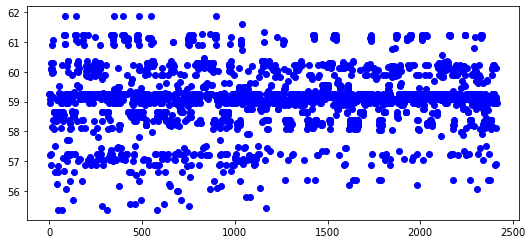

In [ ]:
plt.plot(range(len(y_pred_test)), y_pred_test, 'bo')

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
print("Mean Absolute error on Train data is:{}".format(mean_absolute_error(y_train, y_pred_train)))
print("Mean Absolute error on Val data is:{}".format(mean_absolute_error(y_val, y_pred_val)))

Mean Absolute error on Train data is:3.686522216349326
Mean Absolute error on Val data is:5.549242464558757


In [ ]:
train_df_concat.to_csv("/content/drive/MyDrive/novozymes-enzyme-stability-prediction/train_df_concat.csv")
test_df_concat.to_csv("/content/drive/MyDrive/novozymes-enzyme-stability-prediction/test_df_concat.csv")
val_df_concat.to_csv("/content/drive/MyDrive/novozymes-enzyme-stability-prediction/val_df_concat.csv")
